In [1]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

In [2]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >= 1'
        for i in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))
            
        # post message passing
        self.post_mp = nn.Sequential(
                        nn.Linear(args.heads * hidden_dim, hidden_dim),
                        nn.Dropout(args.dropout),
                        nn.Linear(hidden_dim, output_dim)
                        )
        self.dropout = args.dropout
        self.num_layers = args.num_layers
        self.emb = emb
        
    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT
        
        # GAT 의 num heeads > 1 적용 시킬 때 conv layer 의 input , output dimension을 조정해줘야함.
        # 다음 레이어의 입력 dim이 num heads에 이전 레이어의 출력 dim을 곱한 값이 되도록 합니다.
        # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim))
        # the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.

    def forward(self, data):
        x , edge_index, batch = data.x , data.edge_index, data.batch
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)
            
        x = self.post_mp(x)
        
        if self.emb == True:
            return x
        
        return F.log_softmax(x, dim=1)
    
    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [3]:
class GraphSage(MessagePassing):
    def __init__(self,
                in_channels,
                out_channels,
                normalize = True,
                bias = False,
                 **kwargs
                ):
        super(GraphSage, self).__init__(**kwargs)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        
        # self,lin_l is the linear transformation that you apply to embedding for central node
        # self.lin_r is the linear transformation that you apply to aggregated message from neighbors.
        
        self.lin_l = nn.Linear(self.in_channels, self.out_channels)
        self.lin_r = nn.Linear(self.in_channels, self.out_channels)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()
        
    def forward(self, x, edge_index, size = None):
        out = None
        
        # message passing , as well as any post-processing (update rule).
        # 1. Mesaage passing 을 위한 propagation function 을 불러온다.
        # 1.1 central , neighbourhood information 을 활용하기 위해 x=(x,x) 형식으로 pro가 이뤄짐.
        # 2. skip connection 를 적용하여 node embeedding 정보를 업데이트 한다. 
        # 3. 만약 normalize 를 활용하려면 L-2 normalization 을 활용하라.
        
        prop = self.propagate(edge_index , x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(prop)
        if self.normalize:
            out = F.normalize(out , p=2)
        return out
    
    def message(self, x_j):
        out = None
        
        out = x_j
        
        return out
    
    def aggregate(self, inputs, index, dim_size = None):
        out = None
        
        node_dim = self.node_dim
        
        out = torch_scatter.scatter(inputs,
                                   index,
                                   node_dim,
                                   dim_size=dim_size,
                                   reduce='mean')
        
        return out

graph attention layer 에서 input feature 가 어떻게 변환되는지 관찰해보고자 함.

먼저 , shared linear trnasofrmation parametrized by the $$W \in \mathbb{R}^{F'\times F}$$ 

이 때, W 는 모든 노드에 적용이 된다.

다음은 하단 식과 같이 self-attention 과정을 진행한다.

$$ a : \mathbb{R}^{F'} \times \mathbb{R}{^F} \rightarrow \mathbb{R}.$$

node j 의 feature 이 node i 까지의 중요도를 파악하여 attention 계수를 추출한다.

$$ e_{ij} = a(W_{1}\overset{\rightarrow}{h_{i}}, W_{r}\overset{\rightarrow}{h_j}	)$$

가장 일반적인 self-attention 식은 각각의 노드에 대한 structural information을 누락하게 됨.

이 문제점을 해결하기 위해 masked attention을 활용하게 된다.

masked attention ; 해당 central node , 그리고 연결된 neighbourhood node 간의 e_ij 를 계산하는 형식.

쉽게 타 노드간의 coefficient를 계산하기 위해서 softmax function을 활용한다.

$$a_{ij} = softmax_{j}(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k \in N_{i}}exp(e_{ik})}$$

attention coefficient 를 normalized 하기 위해 각각의 features를 linear combination 하는 과정을 거친다. 해당 aggregated feature 은 모든 node의 final output feature을 의미하며 아래 식과 같다.

$$h'_i = \sum_{j \in N_i} a_{ij}W_r\overset{\rightarrow}{h_j}$$

self-attention 값을 안정화 시키기 위해 multi-head attention을 호라용할 것이며 이를 하기 위해서 각각의 K-independent attention mechanism을 활용 혹은 각각의 output feature을 윗 식과 나타난 'heads' 연산을 접목하여 준다. 그 때 , 우리는 그 output feature들을 concatenate 해줄 것이며 다음 식으로 연산 할 수 있다.

$$\overset{\rightarrow'}{h_i} = ||^K_{k=1}(\sum_{j \in N_i} a^{(k)}_{ij}W_r{^k}\overset{\rightarrow}{h_j}$$

- || 는 concate 
- k 번째 attention mechansim으로부터 계산된 a^k_{ij} 는 normalized attention coefficient
- W^k 는 input 정보가 linear transformation 된 weight matrix 를 의미한다.

# So as a conclusion, _nn.Parameter()_ receives the tensor that is passed  into it, and does not do any initial processing such as uniformization. That means that if the tensor passed into is empty or uninitialized, the  parameter will also be empty or uninitialized. But _nn.Linear() and nn.Embedding()_ initialize their weight tensors with the uniform operation and normalization operation respectively. You won’t get an empty parameter even you only give the shape.

In [4]:
class GAT(MessagePassing):
    def __init__(self,
                 in_channels,
                 out_channels,
                 heads = 2,
                 negative_slope = 0.2,
                 dropout = 0.,
                 **kwargs
                ):
        super(GAT,self).__init__(node_dim=0, **kwargs)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        
        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None
        
        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
        self.lin_r = self.lin_l
        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform(self.lin_l.weight)
        nn.init.xavier_uniform(self.lin_r.weight)
        nn.init.xavier_uniform(self.att_l)
        nn.init.xavier_uniform(self.att_r)
    
    # 1. node embedding 값에 linear transformation을 적용하여 그들을 multiple heads 에 나눠 넣어준다.
    # 2. central node(alpha_l) , neighbor node(alpha_r) 각각의 값들을 계산해준다.
    # 3. message passing 을 위한 propagation function을 불러와준다.
    # 4. output 의 shape 를 N * d dimension으로 변환해준다.
    
    def forward(self, x, edge_index, size=None):
        H , C = self.heads, self.out_channels
        
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index,
                            x = (x_l,x_r),
                             alpha = (alpha_l, alpha_r),
                             size=size
                            )
        out = out.reshape(-1 , H*C)
        
        return out
    
    # 1. alpha i와 alpha_j 를 활용하여 final attention weight를 계산하고 leakly relu를 적용한다.
    # 2. 모든 노드들 각각 해당 cetnral node , neighborhood node 간의 attention 의 값을 softmax 에 적용하여 추출.
    # 3. alpha (attention weight) 에 dropout 을 적용한다.
    # 4. attention weight 와 embedding 값을 곱해준다. 이 때 항상 output shape 는 E(embedding) * H(hidden) * d(dimension) 형태로 존재해야함.
    # 5. ptr (LongTEnsor, optional): CSR 형태의 input 형태로 주어졋을 때 softmax 를 계산해줌.
    
    def message(self,
               x_j,
               alpha_i,
               alpha_j,
               index,
               ptr,
               size_i):
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch.geometric.utils.softmax(alpha_i + alpha_j, index)
        att_weight = F.dropout(att_weight, p=self.dropout)
        out = att_weight * x_j
        
        return out
    
    def aggregate(self,
                 inputs,
                  index,
                  dim_size = None
                 ):
        out = torch_scatter.scatter(inputs,
                                   index,
                                   self.node_dim,
                                    dim_size = dim_size,
                                    reduce = 'reduce'
                                   )
        return out

# Building Optimizer

In [5]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Training and Testing

In [11]:
import time

import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt

def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          print("Epoch ", epoch, "Loss: ", total_loss, "Test Acc.: ", test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            label = data.y
            
        mask = data.val_mask if is_validation else data.test_mask
        pred = pred[mask]
        label = data.y[mask]
        
        correct += pred.eq(label).sum().item()
    
    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
    

Node task. test set size: 140
Epoch  0 Loss:  1.9453397989273071 Test Acc.:  0.154
Epoch  10 Loss:  1.6506879329681396 Test Acc.:  0.446
Epoch  20 Loss:  1.0777796506881714 Test Acc.:  0.574
Epoch  30 Loss:  0.5114810466766357 Test Acc.:  0.64
Epoch  40 Loss:  0.37234821915626526 Test Acc.:  0.672
Epoch  50 Loss:  0.30008625984191895 Test Acc.:  0.656
Epoch  60 Loss:  0.22818832099437714 Test Acc.:  0.706
Epoch  70 Loss:  0.2730034291744232 Test Acc.:  0.67
Epoch  80 Loss:  0.2027338296175003 Test Acc.:  0.672
Epoch  90 Loss:  0.2507677376270294 Test Acc.:  0.656
Epoch  100 Loss:  0.1752457618713379 Test Acc.:  0.696
Epoch  110 Loss:  0.20541924238204956 Test Acc.:  0.7
Epoch  120 Loss:  0.19351528584957123 Test Acc.:  0.69
Epoch  130 Loss:  0.13871902227401733 Test Acc.:  0.664
Epoch  140 Loss:  0.21395446360111237 Test Acc.:  0.7
Epoch  150 Loss:  0.21631689369678497 Test Acc.:  0.68
Epoch  160 Loss:  0.238699808716774 Test Acc.:  0.692
Epoch  170 Loss:  0.16824254393577576 Test Acc.

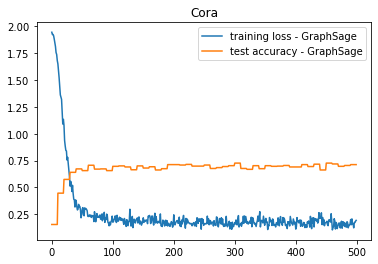

In [12]:
# GraphSage

def main():
    for args in [
        {'model_type' : 'GraphSage',
         'dataset' : 'cora',
         'num_layers' : 2,
         'heads' : 1,
         'batch_size' : 32,
         'hidden_dim' : 32,
         'dropout' : 0.5,
         'epochs' : 500,
         'opt' : 'adam',
         'opt_scheduler': 'none',
         'opt_restart' : 0,
         'weight_decay' : 5e-3,
         'lr' : 0.01       
        },
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model

            if model == 'GAT':
                args.heads = 2
            else:
                args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError('dataset missing')
            test_accs, losses = train(dataset, args)

            print(f'Maximum accuracy : {max(test_accs)}')
            print(f'Minium loss: {min(losses)}')

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
            plt.legend()
            plt.show()

if __name__ == '__main__':
    main()        